In [1]:
#Library 
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error
import optuna
from sklearn.datasets import make_regression
from tqdm import tqdm
import math



In [2]:
! pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o


Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
h2o.init()
hf = h2o.H2OFrame(df)


Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,8 mins 11 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 11 days
H2O_cluster_name:,H2O_from_python_Admin_m920gj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.864 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [7]:
# 1. Importation des librairies nécessaires
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML

# 2. Chargement des données
# Assurez-vous que le chemin vers votre CSV est correct
df = pd.read_csv('final_data/merged_datasets_with_events.csv', sep=',')

# 3. Conversion des colonnes de date en datetime
df['WORK_DATE'] = pd.to_datetime(df['WORK_DATE'])
df['DEB_TIME'] = pd.to_datetime(df['DEB_TIME'])

# 4. Création de nouvelles features temporelles (avant filtrage)
df['month'] = df['WORK_DATE'].dt.month
df['day'] = df['WORK_DATE'].dt.day
df['weekday'] = df['WORK_DATE'].dt.dayofweek
df['hour'] = df['DEB_TIME'].dt.hour
df['minute'] = df['DEB_TIME'].dt.minute

# 5. Filtrage de la période Covid
# On retire les données entre le début et la fin de la période Covid
covid_start = pd.to_datetime('2020-03-01')
covid_stop  = pd.to_datetime('2022-01-01')
df = df[(df['WORK_DATE'] < covid_start) | (df['WORK_DATE'] > covid_stop)]

# 6. Encodage cyclique pour capturer la cyclicité des variables temporelles
def encode_cyclic_feature(df, col, max_val):
    """
    Ajoute deux colonnes (sin et cos) pour encoder une variable cyclique 
    et supprime la colonne d'origine.
    """
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df.drop(columns=[col])

df = encode_cyclic_feature(df, 'month', 12)
df = encode_cyclic_feature(df, 'day', 31)
df = encode_cyclic_feature(df, 'weekday', 7)
df = encode_cyclic_feature(df, 'hour', 24)
df = encode_cyclic_feature(df, 'minute', 60)

# 7. Suppression des colonnes non désirées
# On conserve WAIT_TIME_MAX (notre cible) et les colonnes pertinentes
colonnes_a_supprimer = [
    'DEB_TIME_HOUR', 'NB_UNITS', 'GUEST_CARRIED', 'ADJUST_CAPACITY',
    'NB_MAX_UNIT', 'temp', 'humidity', 'DEB_TIME', 'WORK_DATE',
    'FIN_TIME', 'wind_speed', 'rain_1h', 'rain_3h', 'snow_1h', 'DOWNTIME'
]
# On supprime uniquement les colonnes existantes dans le DataFrame
colonnes_a_supprimer = [col for col in colonnes_a_supprimer if col in df.columns]
df = df.drop(columns=colonnes_a_supprimer)

# 8. Conversion des variables catégorielles (si nécessaire)
# Par exemple, 'weather_description', 'REF_CLOSING_DESCRIPTION', etc.
colonnes_categorielles = ['weather_description', 'REF_CLOSING_DESCRIPTION', 
                          'ENTITY_DESCRIPTION_SHORT', 'NIGHT_SHOW_FLAG', 'PARADE_FLAG']
for col in colonnes_categorielles:
    if col in df.columns:
        df[col] = df[col].astype('category')

# 9. Initialisation de H2O et conversion du DataFrame Pandas en H2OFrame
h2o.init()

hf = h2o.H2OFrame(df)

# Pour H2O, s'assurer que les colonnes catégorielles sont bien traitées en tant que facteurs
for col in colonnes_categorielles:
    if col in hf.columns:
        hf[col] = hf[col].asfactor()

# 10. Définition de la variable cible et des prédicteurs
target = 'WAIT_TIME_MAX'
predictors = [col for col in hf.columns if col != target]

# 11. Division des données en ensembles d'entraînement et de test (par exemple 80/20)
train, test = hf.split_frame(ratios=[0.8], seed=1234)

# 12. Entraînement via H2O AutoML
aml = H2OAutoML(max_models=20, seed=1234, sort_metric='RMSE')
aml.train(x=predictors, y=target, training_frame=train)

# 13. Affichage du leaderboard pour voir les modèles testés
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

# 14. Évaluation du modèle leader sur l'ensemble de test
performance = aml.leader.model_performance(test)
print("RMSE sur le jeu de test :", performance.rmse())
print("MAE sur le jeu de test  :", performance.mae())

# 15. Réaliser des prédictions sur l'ensemble test (optionnel)
predictions = aml.leader.predict(test)
predictions.head()

# 16. (Optionnel) Arrêter le cluster H2O lorsque vous avez terminé
# h2o.shutdown(prompt=False)


Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,16 mins 51 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 11 days
H2O_cluster_name:,H2O_from_python_Admin_m920gj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.867 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
15:26:47.994: AutoML: XGBoost is not available; skipping it.

█████████████████ (cancelled)


H2OJobCancelled: Job<$03017f00000132d4ffffffff$_bb35e5e7575d40408925cd374fc64c2c> was cancelled by the user.

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/faustin/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/faustin/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


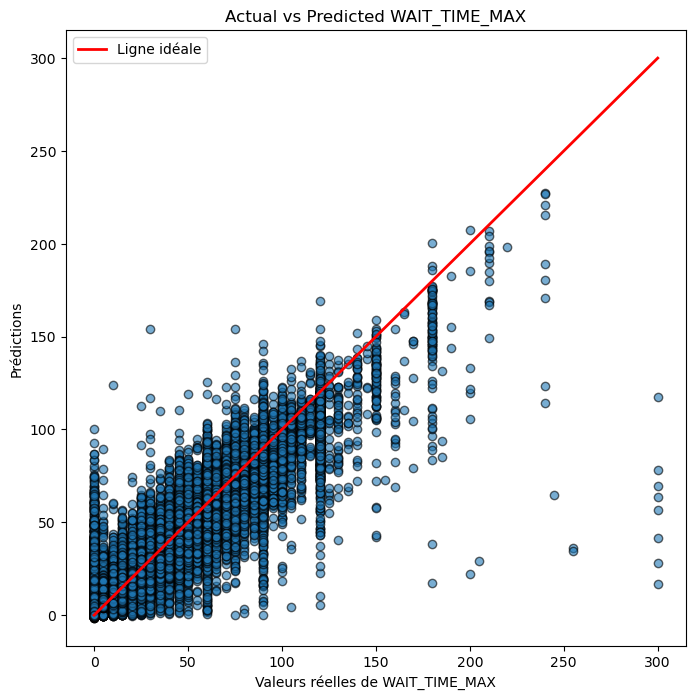

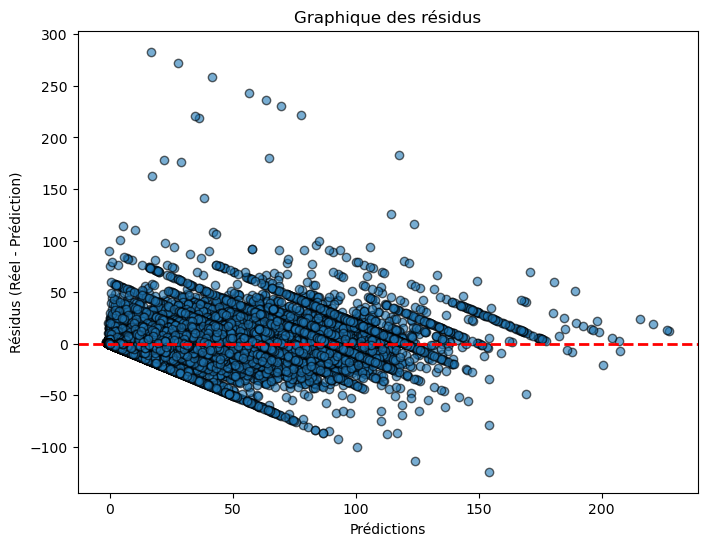

Exemples de données (valeur réelle, prédiction et détails des variables) :
  ENTITY_DESCRIPTION_SHORT  WAIT_TIME_MAX  CAPACITY  OPEN_TIME  UP_TIME  \
0              Giant Wheel             30   503.750         15        0   
1            Haunted House              5   225.000         15       15   
2         Spinning Coaster             40   526.250         15       15   
3              Crazy Dance              5   250.001         15       15   
4            Dizzy Dropper             15   213.251         15       15   
5            Superman Ride             25   243.750         15       15   
6           Roller Coaster             10    75.000         15       15   
7              Bungee Jump              5   306.750         15       15   
8             Giga Coaster             10   705.750         15        0   
9           Flying Coaster              5   756.000         15       15   

   feels_like weather_description REF_CLOSING_DESCRIPTION  ATTENDANCE  \
0       17.89          lig

In [ ]:
# 1. Récupérer le meilleur modèle (leader) à partir de 'aml'
leader_model = aml.leader

# 2. Réaliser des prédictions sur le jeu de test (qui est un H2OFrame)
predictions = leader_model.predict(test)

# 3. Convertir les prédictions et le jeu de test en DataFrame Pandas
pred_df = predictions.as_data_frame()
test_df = test.as_data_frame()

# Assurez-vous que le nom de la colonne cible est bien 'WAIT_TIME_MAX'
target = 'WAIT_TIME_MAX'

# 4. Scatter plot : valeurs réelles vs prédictions
plt.figure(figsize=(8,8))
plt.scatter(test_df[target], pred_df['predict'], alpha=0.6, edgecolors='k')
plt.plot([test_df[target].min(), test_df[target].max()],
         [test_df[target].min(), test_df[target].max()],
         color='red', lw=2, label="Ligne idéale")
plt.xlabel("Valeurs réelles de WAIT_TIME_MAX")
plt.ylabel("Prédictions")
plt.title("Actual vs Predicted WAIT_TIME_MAX")
plt.legend()
plt.show()

# 5. Graphique des résidus : différence entre valeurs réelles et prédictions
residuals = test_df[target] - pred_df['predict']
plt.figure(figsize=(8,6))
plt.scatter(pred_df['predict'], residuals, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Prédictions")
plt.ylabel("Résidus (Réel - Prédiction)")
plt.title("Graphique des résidus")
plt.show()

# 6. Afficher quelques exemples détaillés
# On ajoute la prédiction au DataFrame du jeu de test
test_df['Prédiction'] = pred_df['predict']

print("Exemples de données (valeur réelle, prédiction et détails des variables) :")
print(test_df.head(10))


In [2]:
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2ORandomForestEstimator
import matplotlib.pyplot as plt

# =====================
# Partie 1 : Prétraitement et conversion en H2OFrame
# =====================

# 1. Chargement des données
df = pd.read_csv('final_data/merged_datasets_with_events.csv', sep=',')

# 2. Conversion des colonnes de date en datetime
df['WORK_DATE'] = pd.to_datetime(df['WORK_DATE'])
df['DEB_TIME'] = pd.to_datetime(df['DEB_TIME'])

# 3. Création de nouvelles features temporelles (avant filtrage)
df['month'] = df['WORK_DATE'].dt.month
df['day'] = df['WORK_DATE'].dt.day
df['weekday'] = df['WORK_DATE'].dt.dayofweek
df['hour'] = df['DEB_TIME'].dt.hour
df['minute'] = df['DEB_TIME'].dt.minute

# 4. Filtrage de la période Covid
covid_start = pd.to_datetime('2020-03-01')
covid_stop  = pd.to_datetime('2022-01-01')
df = df[(df['WORK_DATE'] < covid_start) | (df['WORK_DATE'] > covid_stop)]

# 5. Encodage cyclique pour capturer la cyclicité des variables temporelles
def encode_cyclic_feature(df, col, max_val):
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df.drop(columns=[col])

df = encode_cyclic_feature(df, 'month', 12)
df = encode_cyclic_feature(df, 'day', 31)
df = encode_cyclic_feature(df, 'weekday', 7)
df = encode_cyclic_feature(df, 'hour', 24)
df = encode_cyclic_feature(df, 'minute', 60)

# 6. Suppression des colonnes non désirées
colonnes_a_supprimer = [
    'DEB_TIME_HOUR', 'NB_UNITS', 'GUEST_CARRIED', 'ADJUST_CAPACITY',
    'NB_MAX_UNIT', 'temp', 'humidity', 'DEB_TIME', 'WORK_DATE',
    'FIN_TIME', 'wind_speed', 'rain_1h', 'rain_3h', 'snow_1h', 'DOWNTIME'
]
colonnes_a_supprimer = [col for col in colonnes_a_supprimer if col in df.columns]
df = df.drop(columns=colonnes_a_supprimer)

# 7. Conversion des variables catégorielles (si nécessaire)
colonnes_categorielles = ['weather_description', 'REF_CLOSING_DESCRIPTION', 
                          'ENTITY_DESCRIPTION_SHORT', 'NIGHT_SHOW_FLAG', 'PARADE_FLAG']
for col in colonnes_categorielles:
    if col in df.columns:
        df[col] = df[col].astype('category')

# 8. Initialisation de H2O et conversion en H2OFrame
h2o.init()
hf = h2o.H2OFrame(df)

# Conversion des colonnes catégorielles en facteurs dans H2O
for col in colonnes_categorielles:
    if col in hf.columns:
        hf[col] = hf[col].asfactor()

# =====================
# Partie 2 : Entraînement d'un modèle DRF par attraction et affichage de graphiques
# =====================

# Récupérer les prédicteurs globaux (on retire la cible et l'identifiant)
all_cols = hf.columns
predictors_global = [col for col in all_cols if col not in ["WAIT_TIME_MAX", "ENTITY_DESCRIPTION_SHORT"]]

# Récupérer la liste des attractions uniques
unique_attractions = hf["ENTITY_DESCRIPTION_SHORT"].unique().as_data_frame(use_pandas=True).iloc[:,0].tolist()

results = []           # Pour stocker les métriques de chaque attraction
models_per_attraction = {}  # Pour conserver le modèle entraîné pour chaque attraction

# Boucle sur chaque attraction
for attraction in unique_attractions:
    # Filtrer les données pour l'attraction en cours
    data_attraction = hf[hf["ENTITY_DESCRIPTION_SHORT"] == attraction]
    
    # Ne traiter que les attractions avec au moins 50 observations
    if data_attraction.nrows < 50:
        print(f"Skipping attraction {attraction} (only {data_attraction.nrows} rows)")
        continue

    # Définir les prédicteurs pour ce modèle (retirer la cible et l'identifiant)
    predictors = [col for col in data_attraction.columns if col not in ["WAIT_TIME_MAX", "ENTITY_DESCRIPTION_SHORT"]]
    
    # Division en ensembles d'entraînement et de test (80/20)
    splits = data_attraction.split_frame(ratios=[0.8], seed=42)
    train_attraction = splits[0]
    test_attraction  = splits[1]
    
    # Entraîner le modèle DRF (paramètres inspirés du modèle sélectionné)
    drf_model = H2ORandomForestEstimator(
        ntrees=50,
        max_depth=20,
        seed=42
    )
    drf_model.train(x=predictors, y="WAIT_TIME_MAX", training_frame=train_attraction)
    
    # Évaluation sur le jeu de test
    perf = drf_model.model_performance(test_attraction)
    rmse = perf.rmse()
    mae = perf.mae()
    
    results.append({
        "attraction": attraction,
        "n_rows": data_attraction.nrows,
        "rmse": rmse,
        "mae": mae,
        "model_id": drf_model.model_id
    })
    
    models_per_attraction[attraction] = drf_model
    
    # Obtenir les prédictions sur le test et conversion en DataFrame pandas
    pred_attraction = drf_model.predict(test_attraction)
    test_df = test_attraction.as_data_frame()
    pred_df = pred_attraction.as_data_frame()
    
 

# Affichage d'un résumé des performances par attraction
results_df = pd.DataFrame(results)
print("Performance par attraction:")
print(results_df)

# =====================
# Partie 3 : Fonction de prédiction sur de nouvelles données
# =====================

def predict_wait_time(model, input_features: dict):
    """
    Prédit le WAIT_TIME_MAX à partir d'un dictionnaire de features.
    Le dictionnaire input_features doit contenir toutes les variables attendues
    (par exemple : jour, heure, weather_description, température, etc.).
    """
    # Convertir le dictionnaire en DataFrame pandas puis en H2OFrame
    input_df = pd.DataFrame([input_features])
    input_hf = h2o.H2OFrame(input_df)
    
    # Si certaines colonnes catégorielles doivent être considérées comme facteurs,
    # on les convertit ici
    categorical_cols = ['weather_description', 'REF_CLOSING_DESCRIPTION', 
                          'ENTITY_DESCRIPTION_SHORT', 'NIGHT_SHOW_FLAG', 'PARADE_FLAG']
    for col in categorical_cols:
        if col in input_hf.columns:
            input_hf[col] = input_hf[col].asfactor()
    
    # Prédiction
    pred = model.predict(input_hf)
    pred_value = pred.as_data_frame()['predict'][0]
    return pred_value

# Exemple d'utilisation de la fonction de prédiction pour une attraction donnée
exemple_attraction = results_df["attraction"].iloc[0]  # par exemple, le premier de la liste
selected_model = models_per_attraction[exemple_attraction]

# Exemple d'input pour la prédiction : adaptez les noms de variables aux features attendues
input_example = {
    # Remplissez ici avec vos valeurs d'exemple :
    "day_sin": 0.5,
    "day_cos": 0.866,
    "weekday_sin": 0.7,
    "weekday_cos": 0.714,
    "hour_sin": 0.3,
    "hour_cos": 0.954,
    "minute_sin": 0.1,
    "minute_cos": 0.995,
    # Ajoutez les autres features requises, par ex. 'weather_description', etc.
}

predicted_wait_time = predict_wait_time(selected_model, input_example)
print(f"Pour l'attraction {exemple_attraction}, la prédiction de WAIT_TIME_MAX est : {predicted_wait_time}")


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.411-b09, mixed mode)
  Starting server from C:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\fatin\AppData\Local\Temp\tmpxz__458b
  JVM stdout: C:\Users\fatin\AppData\Local\Temp\tmpxz__458b\h2o_Admin_started_from_python.out
  JVM stderr: C:\Users\fatin\AppData\Local\Temp\tmpxz__458b\h2o_Admin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 11 days
H2O_cluster_name:,H2O_from_python_Admin_y4gqc6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.073 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [REF_CLOSING_DESCRIPTION]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [REF_CLOSING_DESCRIPTION]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [NIGHT_SHOW_FLAG]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Performance par attraction:
          attraction  n_rows       rmse       mae  \
0        Bumper Cars   47278   2.952041  1.556259   
1        Bungee Jump   47292   6.270049  3.231214   
2       Circus Train   47280   0.928524  0.287363   
3        Crazy Dance   47277   0.741806  0.139344   
4      Dizzy Dropper   47294   2.777966  1.366607   
5         Drop Tower   47285   4.961366  2.735650   
6     Flying Coaster   47286   5.242757  3.137811   
7          Free Fall   47287  10.975262  5.569394   
8        Giant Wheel   47276  10.222723  6.557731   
9       Giga Coaster   47272   3.599841  1.603385   
10          Go-Karts   47293   8.863408  4.991730   
11     Haunted House   47279   4.680361  2.845034   
12     Himalaya Ride   47281   0.380104  0.057073   
13  Inverted Coaster   47285   5.328248 

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Pour l'attraction Bumper Cars, la prédiction de WAIT_TIME_MAX est : 5.8


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'weather_description': substitu

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialiser une liste pour stocker les DataFrames de prédictions pour chaque attraction
predictions_all = []

# Pour chaque attraction ayant un modèle entraîné
for attraction in unique_attractions:
    # On ne prend en compte que celles pour lesquelles on a entraîné un modèle
    if attraction not in models_per_attraction:
        continue
    model = models_per_attraction[attraction]
    
    # Filtrer l'ensemble des données pour cette attraction depuis le H2OFrame complet
    # (Ici, on utilise toutes les observations pour l'attraction.
    # Vous pouvez adapter pour utiliser un sous-ensemble "test" si vous l'avez défini.)
    test_attraction = hf[hf["ENTITY_DESCRIPTION_SHORT"] == attraction]
    
    # Effectuer la prédiction avec le modèle DRF de cette attraction
    pred_hf = model.predict(test_attraction)
    
    # Convertir le sous-ensemble test et les prédictions en DataFrame pandas
    test_df = test_attraction.as_data_frame()
    pred_df = pred_hf.as_data_frame()
    
    # Ajouter la colonne des prédictions dans le DataFrame
    test_df["predicted_WAIT_TIME_MAX"] = pred_df["predict"]
    
    # Calculer le résidu (erreur) pour chaque observation
    test_df["residual"] = test_df["WAIT_TIME_MAX"] - test_df["predicted_WAIT_TIME_MAX"]
    
    # Ajouter une colonne indiquant l'attraction
    test_df["attraction"] = attraction
    
    predictions_all.append(test_df)

# Concaténer toutes les prédictions en un seul DataFrame
final_predictions = pd.concat(predictions_all, axis=0)

# Calculer les métriques globales sur l'ensemble des prédictions
global_rmse = np.sqrt(mean_squared_error(final_predictions["WAIT_TIME_MAX"], final_predictions["predicted_WAIT_TIME_MAX"]))
global_mae  = mean_absolute_error(final_predictions["WAIT_TIME_MAX"], final_predictions["predicted_WAIT_TIME_MAX"])

print("Global RMSE :", global_rmse)
print("Global MAE  :", global_mae)

# Afficher quelques lignes du jeu de données test avec les prédictions
print("\nAperçu du jeu de données test avec prédictions :")
print(final_predictions.head())

# Optionnel : Sauvegarder le jeu de données final dans un fichier CSV
# final_predictions.to_csv("test_predictions_all_attractions.csv", index=False)


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Global RMSE : 4.0049010682457675
Global MAE  : 1.688569233497468

Aperçu du jeu de données test avec prédictions :
  ENTITY_DESCRIPTION_SHORT  WAIT_TIME_MAX  CAPACITY  OPEN_TIME  UP_TIME  \
0              Bumper Cars              0       0.0          0        0   
1              Bumper Cars              0       0.0          0        0   
2              Bumper Cars              0       0.0          0        0   
3              Bumper Cars              0       0.0          0        0   
4              Bumper Cars              0       0.0          0        0   

   feels_like weather_description REF_CLOSING_DESCRIPTION  ATTENDANCE  \
0       17.05     overcast clouds        Fermeture RÃ©hab       46804   
1       20.62          light rain        Fermeture RÃ©hab       46804   
2       19.69     overcast clouds        Fermeture RÃ©hab       46804   
3       18.73     overcast clouds        Fermeture RÃ©hab       46804   
4       17.05     overcast clouds        Fermeture RÃ©hab       46804

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Agenda de prédiction du WAIT_TIME_MAX (toutes les 15 minutes) :
              datetime  predicted_WAIT_TIME_MAX
0  2025-02-13 10:00:00                 5.100000
1  2025-02-13 10:15:00                 5.100000
2  2025-02-13 10:30:00                 5.750000
3  2025-02-13 10:45:00                 8.750000
4  2025-02-13 11:00:00                11.300000
5  2025-02-13 11:15:00                14.400000
6  2025-02-13 11:30:00                16.291818
7  2025-02-13 11:45:00                16.246104
8  2025-02-13 12:00:00                18.718963
9  2025-02-13 12:15:00                19.318963
10 2025-02-13 12:30:00                19.587233
11 2025-02-13 12:45:00                19.452297
12 2025-02-13 13:00:00                19.469904
13 2025-02-13 13:15:00                20.169904
14 2025-02-13 13:30:00                19.869051
15 2025-02-13 13:45:00                19.768389
16 2025-02-13 14:00:00   

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

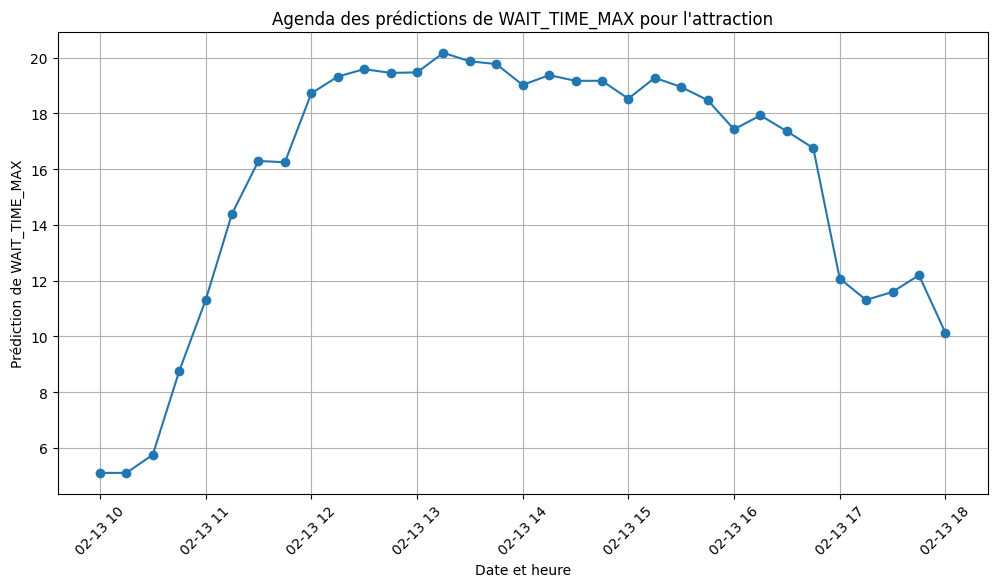

In [7]:
import pandas as pd
import numpy as np
import datetime

def generate_schedule(model, date_str, open_time_str, close_time_str, weather_description, attendance, additional_features=None):
    """
    Génère un agenda de prédictions de WAIT_TIME_MAX pour une attraction pour une journée donnée.
    
    Paramètres:
      - model: le modèle H2O (par exemple, issu de models_per_attraction) à utiliser pour la prédiction.
      - date_str: date de la prédiction sous forme de chaîne (ex: '2025-02-13').
      - open_time_str: heure d'ouverture au format 'HH:MM' (ex: '10:00').
      - close_time_str: heure de fermeture au format 'HH:MM' (ex: '18:00').
      - weather_description: description de la météo (ex: 'light rain').
      - attendance: affluence du jour (ex: 46804).
      - additional_features: dictionnaire optionnel contenant d'autres variables attendues par le modèle 
                              (par exemple, {'REF_CLOSING_DESCRIPTION': 'Open', 'NIGHT_SHOW_FLAG': 0, 'PARADE_FLAG': 0}).
    
    Retourne un DataFrame pandas contenant pour chaque créneau (toutes les 15 minutes) la date/heure et la prédiction.
    """
    # Convertir les chaînes en objets datetime
    date_obj = pd.to_datetime(date_str)
    open_dt = pd.to_datetime(f"{date_str} {open_time_str}")
    close_dt = pd.to_datetime(f"{date_str} {close_time_str}")
    
    # Initialiser la liste pour stocker l'agenda
    schedule = []
    current_dt = open_dt
    
    while current_dt <= close_dt:
        # Pour la date donnée, les valeurs jour, mois et jour de la semaine restent constantes
        month = date_obj.month
        day = date_obj.day
        weekday = date_obj.dayofweek  # 0 = lundi, 6 = dimanche
        
        # Pour l'heure actuelle
        hour = current_dt.hour
        minute = current_dt.minute
        
        # Calcul des encodages cycliques
        month_sin = np.sin(2 * np.pi * month / 12)
        month_cos = np.cos(2 * np.pi * month / 12)
        day_sin = np.sin(2 * np.pi * day / 31)
        day_cos = np.cos(2 * np.pi * day / 31)
        weekday_sin = np.sin(2 * np.pi * weekday / 7)
        weekday_cos = np.cos(2 * np.pi * weekday / 7)
        hour_sin = np.sin(2 * np.pi * hour / 24)
        hour_cos = np.cos(2 * np.pi * hour / 24)
        minute_sin = np.sin(2 * np.pi * minute / 60)
        minute_cos = np.cos(2 * np.pi * minute / 60)
        
        # Constitution du dictionnaire d'input pour le modèle.
        # Veillez à ce que les clés correspondent exactement aux noms de colonnes attendus par votre modèle.
        input_features = {
            "month_sin": month_sin,
            "month_cos": month_cos,
            "day_sin": day_sin,
            "day_cos": day_cos,
            "weekday_sin": weekday_sin,
            "weekday_cos": weekday_cos,
            "hour_sin": hour_sin,
            "hour_cos": hour_cos,
            "minute_sin": minute_sin,
            "minute_cos": minute_cos,
            "weather_description": weather_description,
            "ATTENDANCE": attendance  # si votre modèle utilise cette variable
        }
        # Ajout des éventuelles variables supplémentaires
        if additional_features is not None:
            input_features.update(additional_features)
        
        # Prédiction à l'aide de la fonction prédéfinie predict_wait_time
        pred_wait = predict_wait_time(model, input_features)
        
        schedule.append({
            "datetime": current_dt,
            "predicted_WAIT_TIME_MAX": pred_wait
        })
        
        # Passage au créneau suivant (15 minutes)
        current_dt += datetime.timedelta(minutes=15)
    
    schedule_df = pd.DataFrame(schedule)
    return schedule_df

# Exemple d'utilisation :
# On suppose que 'selected_model' est le modèle pour une attraction spécifique (par exemple, celui avec la MAE la plus faible)
# Vous pouvez adapter les valeurs ci-dessous selon les besoins de votre client

date_example = "2025-02-13"
open_time_example = "10:00"
close_time_example = "18:00"
weather_example = "light rain"
attendance_example = 46804

# Optionnel : d'autres features attendues par le modèle (exemple)
additional_features_example = {
    "REF_CLOSING_DESCRIPTION": "Open",
    "NIGHT_SHOW_FLAG": 0,
    "PARADE_FLAG": 0
}

# Générer l'agenda pour l'attraction sélectionnée
schedule_df = generate_schedule(selected_model, date_example, open_time_example, close_time_example, 
                                weather_example, attendance_example, additional_features_example)

# Afficher l'agenda
print("Agenda de prédiction du WAIT_TIME_MAX (toutes les 15 minutes) :")
print(schedule_df)

# Optionnel : tracer l'évolution du temps d'attente prédit sur la journée
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(schedule_df["datetime"], schedule_df["predicted_WAIT_TIME_MAX"], marker='o')
plt.xlabel("Date et heure")
plt.ylabel("Prédiction de WAIT_TIME_MAX")
plt.title("Agenda des prédictions de WAIT_TIME_MAX pour l'attraction")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |

c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'CAPACITY': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'OPEN_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'UP_TIME': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'feels_like': substituting in a column of NaN
  warnings.warn(w)
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread

Global RMSE pour Oz Theatre le 2018-06-01 : 0.57
Global MAE pour Oz Theatre le 2018-06-01 : 0.41


C:\Users\fatin\AppData\Local\Temp\ipykernel_984\1625542317.py:59: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_actual['time_slot'] = df_actual['DEB_TIME'].dt.floor('15T')


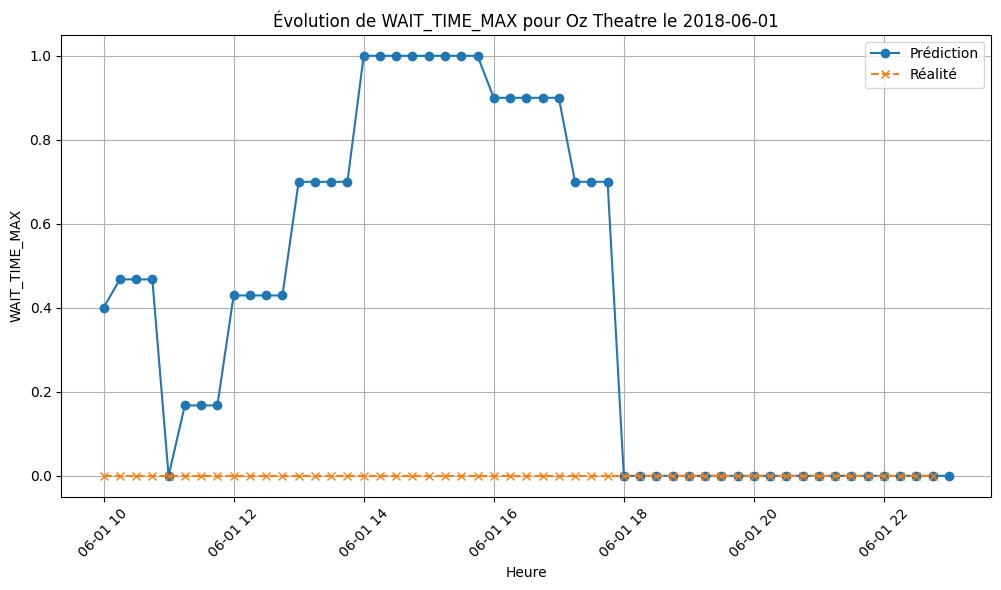

In [12]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

# -----------------------------
# PARTIE 1 : Génération de l'agenda de prédictions pour une attraction donnée
# -----------------------------

# Choisissez l'attraction, ici "Circus Train"
attraction_name = "Oz Theatre"

# Vérifier que le modèle pour cette attraction est disponible :
if attraction_name in models_per_attraction:
    model_ct = models_per_attraction[attraction_name]
else:
    print(f"L'attraction {attraction_name} n'est pas disponible dans les modèles.")
    # Optionnel : utiliser une autre attraction (par exemple, la première disponible)
    attraction_name = results_df["attraction"].iloc[0]
    model_ct = models_per_attraction[attraction_name]
    print(f"Utilisation de {attraction_name} à la place.")

# Définir les paramètres de la journée à prédire
date_example = "2018-06-01"
open_time_example = "10:00"
close_time_example = "23:00"
weather_example = "light rain"
attendance_example = 46804


# Dictionnaire des éventuelles variables supplémentaires attendues par le modèle
additional_features_example = {
    "REF_CLOSING_DESCRIPTION": "Fermeture Réhab",
    "NIGHT_SHOW_FLAG": 0,
    "PARADE_FLAG": 0
}

# Générer l'agenda de prédictions pour l'attraction choisie
schedule_ct = generate_schedule(model_ct, date_example, open_time_example, close_time_example, 
                                weather_example, attendance_example, additional_features_example)
# La fonction generate_schedule retourne un DataFrame avec les colonnes "datetime" et "predicted_WAIT_TIME_MAX"

# -----------------------------
# PARTIE 2 : Extraction des données réelles pour la même attraction et journée
# -----------------------------

# Recharger le CSV original (celui contenant les informations de date et heure)
df_original = pd.read_csv('final_data/merged_datasets_with_events.csv', sep=',')

# Conversion des colonnes de date en datetime
df_original['WORK_DATE'] = pd.to_datetime(df_original['WORK_DATE'])
df_original['DEB_TIME'] = pd.to_datetime(df_original['DEB_TIME'])

# Filtrer pour l'attraction choisie et la date donnée
df_actual = df_original[(df_original['ENTITY_DESCRIPTION_SHORT'] == attraction_name) & 
                        (df_original['WORK_DATE'].dt.date == pd.to_datetime(date_example).date())].copy()

# On suppose que chaque observation correspond à un événement ; on arrondit l'heure de début (DEB_TIME) au créneau de 15 minutes
df_actual['time_slot'] = df_actual['DEB_TIME'].dt.floor('15T')

# Agréger en calculant la moyenne du WAIT_TIME_MAX par créneau (s'il y a plusieurs observations par créneau)
df_actual_grouped = df_actual.groupby('time_slot')['WAIT_TIME_MAX'].mean().reset_index()

# -----------------------------
# PARTIE 3 : Fusion et visualisation des prédictions vs réalité
# -----------------------------

# Convertir la colonne "datetime" du schedule en datetime (si ce n'est déjà fait)
schedule_ct['datetime'] = pd.to_datetime(schedule_ct['datetime'])

# Fusionner sur les créneaux horaires (ici, la fusion est faite sur "datetime" et "time_slot")
merged_df = pd.merge(schedule_ct, df_actual_grouped, left_on='datetime', right_on='time_slot', how='left')

# Affichage des métriques globales pour cette journée (optionnel)
from sklearn.metrics import mean_squared_error, mean_absolute_error
if merged_df['WAIT_TIME_MAX'].notnull().sum() > 0:
    global_rmse = np.sqrt(mean_squared_error(merged_df['WAIT_TIME_MAX'].dropna(), merged_df['predicted_WAIT_TIME_MAX'][merged_df['WAIT_TIME_MAX'].notnull()]))
    global_mae  = mean_absolute_error(merged_df['WAIT_TIME_MAX'].dropna(), merged_df['predicted_WAIT_TIME_MAX'][merged_df['WAIT_TIME_MAX'].notnull()])
    print(f"Global RMSE pour {attraction_name} le {date_example} : {global_rmse:.2f}")
    print(f"Global MAE pour {attraction_name} le {date_example} : {global_mae:.2f}")
else:
    print("Aucune donnée réelle disponible pour cette date.")

# Tracer le graphique comparant les prédictions et les valeurs réelles
plt.figure(figsize=(12,6))
plt.plot(merged_df['datetime'], merged_df['predicted_WAIT_TIME_MAX'], marker='o', label="Prédiction")
plt.plot(merged_df['datetime'], merged_df['WAIT_TIME_MAX'], marker='x', linestyle='--', label="Réalité")
plt.xlabel("Heure")
plt.ylabel("WAIT_TIME_MAX")
plt.title(f"Évolution de WAIT_TIME_MAX pour {attraction_name} le {date_example}")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


In [14]:
  # Save each model to a dedicated folder (e.g., "models/")
import os

models_dir = "models"
os.makedirs(models_dir, exist_ok=True)

for attraction, model in models_per_attraction.items():
    # Create a safe filename by replacing spaces or forbidden characters
    safe_name = attraction.replace(" ", "_")
    model_path = h2o.save_model(model=model, path=models_dir, force=True)
    # Optionally, rename or move the file to include the attraction name:
    new_path = os.path.join(models_dir, f"model_{safe_name}")
    os.rename(model_path, new_path)
    print(f"Saved model for {attraction} at: {new_path}")


Saved model for Bumper Cars at: models\model_Bumper_Cars
Saved model for Bungee Jump at: models\model_Bungee_Jump
Saved model for Circus Train at: models\model_Circus_Train
Saved model for Crazy Dance at: models\model_Crazy_Dance
Saved model for Dizzy Dropper at: models\model_Dizzy_Dropper
Saved model for Drop Tower at: models\model_Drop_Tower
Saved model for Flying Coaster at: models\model_Flying_Coaster
Saved model for Free Fall at: models\model_Free_Fall
Saved model for Giant Wheel at: models\model_Giant_Wheel
Saved model for Giga Coaster at: models\model_Giga_Coaster
Saved model for Go-Karts at: models\model_Go-Karts
Saved model for Haunted House at: models\model_Haunted_House
Saved model for Himalaya Ride at: models\model_Himalaya_Ride
Saved model for Inverted Coaster at: models\model_Inverted_Coaster
Saved model for Kiddie Coaster at: models\model_Kiddie_Coaster
Saved model for Merry Go Round at: models\model_Merry_Go_Round
Saved model for Oz Theatre at: models\model_Oz_Theatre
S